# Podstawy Sieci Neuronowych
## Projekt 1
*Autor:* Aliaksandr Kandrat  
*Nr. indeksu:* 264290  
*Semestr:* 5  
*Grupa:* Poniedziałek, 9:15-11:00  
*Prowadzący:* Dr. inż. Piotr Ciskowski  

### Wstęp

Tematem tego projektu było zapoznanie się z **płytkimi sieciami neuronowymi** (*ang. shallow neural networks*). Płytkie sieci neuronowe różnią cię od glębokich tym, że składają się z kilku warstw, np. *warstwy wejściowej, jednej warstwy ukrytej oraz warstwy wyjsciowej*, gdyż głębokie sieci neuronowe mogą składać się z dziesiątek, a nawet setek warstw ukrytych.  

Ponieważ są to sieci płytkie, zby lepiej zrozumieć całą teorię uczenia sieci zdecydowałem stworzyć ten program  
bez wykorzystania gotowych bibliotek do uczenia sieci, samodzielnie implementując wszystkie potrzebne funkcje.  

Jako główny problem, dla którego została stworzona ta sieć, wybrałęm popularny zbiór danych **MNIST database** (*Modified National Institute of Standards and Technology database*), opis którego można znaleźć dalej.


### Importowanie zależności

Do samodzielnego stworzenia sieci neuronowej wykorzystałem następujące biblioteki:
- **NumPy** - biblioteka dodająca obsługę dużych wielowymiarowych macierzy i tabel oraz operacji matematycznych.
- **Matplotlib** - biblioteka pozwalająca na stworzenie różnego rodzaju wykresów.  
- **Pandas** - biblioteka, którą wykorzystamy do działań na tabelach oraz plikach **.csv**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Opis problemu

Jak już było powiedziano, będziemy tworzyli płytką sieć neuronową do klasyfikacji danych ze zbioru **MNIST**.  
Zbiór ten składa się z 70,000 czarno-białych obrazów o rozmiarze 28x28 pikseli. Każdy z obrazów zawiera odręcznie  
napisaną cyfrę `[0...9]`. Każdy obraz jest podpisany etykietą odpowiadającą liczbie na obrazie.  

Głównym zadaniem jest stworzenie sieci płytkiej, składającej się z **warstwy wejściowej, warstwy ukrytej oraz  
warstwy wyjściowej**, która byłaby w stanie klasyfikować odręcznie napisane cyfry z tego zbioru.  


### Przygotowanie danych

Zbiór danych **MNIST** został pobrany z [Kaggle](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv).  
Na tej stronie jest on przedstawiony w postaci dwóch plików **.csv**: *mnist_train.csv* oraz  
*mnist_test.csv*. Plik *mnist_test.csv* zawiera w sobie dane o 60,000 obrazach do uczenia sieci,  
a plik *mnist_test.csv* zawiera 10,000 obrazów do testowania.  

Dane w tych plikach są przedstawione w postaci liczbowej. Rozpatrzymy jak są przedstawione dane  
na przykładzie danych uczących. Plik *mnist_train.csv* składa się s 60,000 wierszy, gdzie każdy  
wiersz odpowiada jednemu obrazowi. Każdy wiersz składa się z 785 kolumn. Pierwsza kolumna jest  
etykietą, odpowiadającą liczbie na obrazie. Następne 784 kolumny zawierają wartości [0...255],  
odpowiadające wartościom pikseli obrazu 28x28, gdzie `0 - czarny`, a `255 - biały` kolor.  

Pliki danych zostały zapiane do folderu *datasets/*. Dane z plików możemy pobrać następująco:

In [2]:
data_train_csv = pd.read_csv('datasets/mnist_train.csv')
data_test_csv = pd.read_csv('datasets/mnist_test.csv')

Następnie, musimy doprowadzić nasze dane go wymaganej postaci. Przy pomocy zmiennej `N_samples`  
wybieramy ilość przykładów do uczenia sieci (*max. 60,000*). Dalej, zmienimy rozmiar naszych  
z (60.000, 785) na (785, 60.000), tak aby każdemy przykładowi odpowiadała jedna kolumna.  
Teraz podzielimy nasz zbiór uczący na etykiety i obrazy. Po transponowaniu danych testowych,  
etykietom odpowiada pierwszy wiersz, a wszystkie następne 784 są danymi o pikselach obrazów.  
Ostatnią ważną rzeczą jest normalizacja wartości pikseli z przedziału [0...255] do [0...1]. W  
tym celu podzielimy wszystkie wartości na 255.

In [3]:
# number of training samples
N_samples = 60000
# number of sample's features
N_features = 784
data_train = np.array(data_train_csv)[:N_samples].T
Y_train = data_train[0].copy()
X_train = data_train[1:].copy()/255

Na wykresie poniżej możemy zobaczyć, jak wyglądają dane z którymi będziemy pracować:

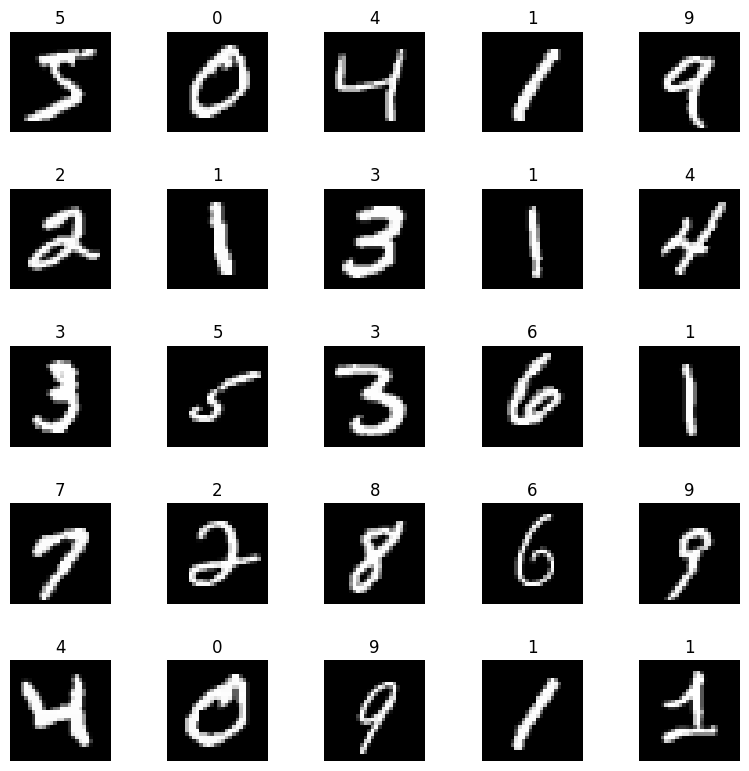

In [13]:
fig, axes = plt.subplots(5, 5, figsize=[8, 8])
fig.tight_layout(pad=1.0)
axes = axes.ravel()
for i in range (25):
  axes[i].imshow(X_train[:, i].reshape((28, 28)))
  axes[i].set_title(Y_train[i])
  axes[i].axis('off')

plt.show()

W wyniku, zbiór uczący jest przedstawiony przez dwie zmienne: `X_train` o rozmiarach (784, 60000), gdzie każda kolumna jest obrazem, oraz `Y_train` o rozmiarach (60000, ), które jest tablicą etykiet.

In [4]:
print(X_train.shape)
print(Y_train.shape)

(784, 60000)
(60000,)


W ten sam sposób przygotujemy dane ze zbioru testowego:

In [5]:
data_test = np.array(data_test_csv).T
Y_test = data_test[0].copy()
X_test = data_test[1:].copy() / 255

### Implementacja funkcji

Poniżej są przedstawione wszystkie funkcje, stworzone przy pomocy wyłącznie zaimportowanych  
wcześniej bibliotek. Każda funkcja posiada dokładny opis oraz niezbędne komentarze.

In [6]:
def initNetwork(K: int) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Network initialization.
    
    This function initializes weights and biases for the network of shape 
    (784 - K - 10), where `784` is number of inputs with values in range [0, 1],
    `K` is a number of neurons in the hidden layer and `10` is a number of 
    output classes. Weights and biases are initialized with values from a 
    uniform distribution [0, 1) scaled to (-0.1, 0.1) range.
    
    ### Parameters:
    - `K: int` - number of neurons in the hidden layer
    
    ### Returns:
    - `W1: np.array` - weights matrix, `shape=(K, 784)` for the first layer
    - `b1: np.array` - biases matrix, `shape=(K, 1)` for the first layer
    - `W2: np.array` - weights matrix, `shape=(10, K)` for the second layer
    - `b2: np.array` - biases matrix, `shape=(10, 1)` for the second layer
    """
    W1 = np.random.rand(K, 784) * 0.2 - 0.1
    b1 = np.random.rand(K, 1) * 0.2 - 0.1
    W2 = np.random.rand(10, K) * 0.2 - 0.1
    b2 = np.random.rand(10, 1) * 0.2 - 0.1
    
    return W1, b1, W2, b2

def ReLU(U:np.ndarray):
    """
    Rectified linear unit (ReLU) function.
    
    Applies ReLU function elementwise to the input vector.
    """
    return np.maximum(U, 0)

def softmax(U:np.ndarray):
    """
    Softmax function.
    
    Applies Softmax function element-wise to the input vector.
    """
    exp = np.exp(U)
    return exp / sum(exp)

def forwardPropagation(X:np.ndarray, W1:np.ndarray, b1:np.ndarray, W2:np.ndarray, b2:np.ndarray):
    """
    Execute a forward propagation step.
    
    Starts a forward propagation step with the given parameters. On the network
    with of shape (784 - K - 10), where `784` is number of inputs with values in
    range [0, 1], `K` is a number of neurons in the hidden layer and `10` is a 
    number of output classes.
    
    ### Parameters:
    - `X: np.array` - input vector, `shape=(784, 1)`. Values in range [0, 1]
    - `W1: np.array` - weights matrix for the first layer (input -> hidden)
    - `b1: np.array` - biases matrix for the first layer (input -> hidden)
    - `W2: np.array` - weights matrix for the second layer (hidden -> output)
    - `b2: np.array` - biases matrix for the second layer (hidden -> output)
    
    ### Returns:
    - `U1: np.array` - pre-activation output of the first layer, `shape=(K, 1)`
    - `Y1: np.array` - output of the first layer with applied `ReLU` function
    - `U2: np.array` - pre-activation output of the first layer, `shape=(10, 1)`
    - `Y2: np.array` - output of the second layer with applied `softmax` function
    """
    U1 = W1.dot(X) + b1
    Y1 = ReLU(U1)
    U2 = W2.dot(Y1) + b2
    Y2 = softmax(U2)
    
    return U1, Y1, U2, Y2

def oneHot(Y):
    """
    Create a one-hot matrix for the given array.
    """
    n_elements = Y.size
    one_hot_Y = np.zeros((10, n_elements))
    one_hot_Y[Y, np.arange(n_elements)] = 1
    return one_hot_Y

def MSE(D):
    """
    Calculate the MSE for given array.
    
    ### Parameters:
    - `D: np.array` - array with values `A_1 - A_2`, where `A_1` and `A_2` are
    the two arrays, for which MSE is calculated.
    """
    return np.mean(np.square(D))

def ReLUDerivative(U):
    """
    Return the result of element-wise ReLU derivative calculation.
    """
    return U > 0

def backwardPropagation(U1, Y1, U2, Y2, W1, b1, W2, b2, X, Y):
    """
    Execute a backward propagation step.
    
    Starts a forward propagation step with the given parameters.
    
    ### Parameters:
    - `U1: np.array` - pre-activation output of the first layer, `shape=(K, 1)`
    - `Y1: np.array` - output of the first layer with applied `ReLU` function
    - `U2: np.array` - pre-activation output of the first layer, `shape=(10, 1)`
    - `Y2: np.array` - output of the second layer with applied `softmax` function
    - `W1: np.array` - weights matrix for the first layer (input -> hidden)
    - `b1: np.array` - biases matrix for the first layer (input -> hidden)
    - `W2: np.array` - weights matrix for the second layer (hidden -> output)
    - `b2: np.array` - biases matrix for the second layer (hidden -> output)
    - `X: np.array` - input vector, `shape=(784, 1)`. Values in range [0, 1]
    - `Y: np.array` - array of desired outputs (labels)
    
    ### Returns:
    - `dW1: np.array` - corrections for weights matrix of the first layer
    - `db1: np.array` - corrections for biases matrix of the first layer
    - `dW2: np.array` - corrections for weights matrix of the second layer
    - `db2: np.array` - corrections for biases matrix of the second layer
    - `error: float` - MSE of output compared to labels
    """
    n_samples = Y.size
    one_hot_Y = oneHot(Y)
    D2 = Y2 - one_hot_Y
    error = MSE(D2)
    dW2 = 1/n_samples * (2*D2).dot(Y1.T)
    db2 = 1/n_samples * 2 * np.sum(D2)
    D1 = W2.T.dot(D2) * ReLUDerivative(U1)
    dW1 = 1/n_samples * (2*D1).dot(X.T)
    db1 = 1/n_samples * 2 * np.sum(D1)
    
    return dW1, db1, dW2, db2, error

def updateParams(W1, b1, W2, b2, dW1, db1, dW2, db2, lr, dW1_prev, db1_prev, dW2_prev, db2_prev):
    """
    Update the weights matrices with given corrections.
    
    ### Parameters:
    - `W1: np.array` - weights matrix for the first layer (input -> hidden)
    - `b1: np.array` - biases matrix for the first layer (input -> hidden)
    - `W2: np.array` - weights matrix for the second layer (hidden -> output)
    - `b2: np.array` - biases matrix for the second layer (hidden -> output)
    - `dW1: np.array` - corrections for weights matrix of the first layer
    - `db1: np.array` - corrections for biases matrix of the first layer
    - `dW2: np.array` - corrections for weights matrix of the second layer
    - `db2: np.array` - corrections for biases matrix of the second layer
    - `lr: float` - learning rate
    
    ### Returns:
    - `W1: np.array` - updated weights matrix for the first layer
    - `b1: np.array` - updated biases matrix for the first layer
    - `W2: np.array` - updated weights matrix for the second layer
    - `b2: np.array` - updated biases matrix for the second layer
    """
    ndW1 = (lr * dW1 + (1-lr)*dW1_prev)
    ndb1 = (lr * db1 + (1-lr)*db1_prev)
    ndW2 = (lr * dW2 + (1-lr)*dW2_prev)
    ndb2 = (lr * db2 + (1-lr)*db2_prev)
    W1 -= ndW1
    b1 -= ndb1
    W2 -= ndW2
    b2 -= ndb2
    
    return W1, b1, W2, b2, ndW1, ndb1, ndW2, ndb2


In [7]:
def getPredictions(Y):
    """
    Get predictions from the NN output vector.
    
    ### Parameters:
    - `Y: np.array` - output of the NN
    
    ### Returns:
    - `np.array` - array of classes' numbers
    """
    
    return np.argmax(Y, 0)

def getAccuracy(pred, T):
    """
    Get accuracy of the NN
    
    ### Parameters:
    - `pred: np.array` - array of NN predictions
    - `T: np.array` - desired output (labels)
    
    ### Returns:
    - `float` - percent value of NN accuracy
    """
    
    return np.sum(pred==T)/T.size


def getTestAccuracy(TX, TY, W1, b1, W2, b2):
    """
        Get network's accuracy on a test set.
        
        ### Parameters:
        - `TX: np.ndarray` - test set images
        - `TY: np.ndarray` - test set labels
        - `W1: np.ndarray` - trained weights matrix for the first layer
        - `b1: np.ndarray` - trained biases matrix for the first layer
        - `W2: np.ndarray` - trained weights matrix for the second layer
        - `b2: np.ndarray` - trained biases matrix for the second layer
        
        ### Returns:
        - 'float' - percent value of NN accuracy
    """
    predictions = makePredictions(TX, W1, b1, W2, b2)
    accuracy_test = getAccuracy(predictions, TY)
    return accuracy_test

def miniBatchGradientDescent(X, Y, K, lr, iterations, batchSize, TX, TY, decay=0):
    """
    Train the NN using given parameters for a given number of epochs using 
    mini-batch method with learging rate decay and momentum. Uses mean squared error  
    as a loss function.
    
    ### Parameters:
    - `X: np.array` - input vector, `shape=(784, 1)`. Values in range [0, 1]
    - `Y: np.array' - array of desired outputs (labels)
    - `K: int` - number of neurons in the hidden layer
    - `lr: float` - learning rate
    - `iterations: int` - number of epochs
    - `batchSize: int` - number of samples in mini-batch
    
    
    ### Returns:
    - `W1: np.array` - trained weights matrix for the first layer
    - `b1: np.array` - trained biases matrix for the first layer
    - `W2: np.array` - trained weights matrix for the second layer
    - `b2: np.array` - trained biases matrix for the second layer
    """
    W1, b1, W2, b2 = initNetwork(K)
    history = {"accuracy_train" : list(),
               "accuracy_test" : list(),
               "error" : list()}
    dW1_prev, db1_prev, dW2_prev, db2_prev = 0.0, 0.0, 0.0, 0.0
    
    predictions = makePredictions(X, W1, b1, W2, b2)
    accuracy_train = getAccuracy(predictions, Y)
    accuracy_test = getTestAccuracy(TX, TY, W1, b1, W2, b2)
    print(f"Train prediction: {accuracy_train} and test: {accuracy_test}")
    
    for i in range(iterations):
        # divide given X dataset into smaller 'mini-batches'
        # 1) calculate the number of batches
        n_samples = X.shape[1]
        # a number of full mini-batches
        n_full_batches = n_samples // batchSize
        lr = lr * 1.0/(1.0 + decay*i)
        # the last mini-batch may not be of size `batchSize`
        for b in range(n_full_batches+1):
            mbatch_start = b * batchSize
            mbatch_end = mbatch_start + batchSize
            if b == n_full_batches:
                X_mini = X[:, mbatch_start:]
                Y_mini = Y[mbatch_start:]
            else:
                X_mini = X[:, mbatch_start:mbatch_end]
                Y_mini = Y[mbatch_start:mbatch_end]
            
            # after we have devided dataset into smaller batches
            # we have to train the NN on every mini-batch
            # and update the parameters after every mini-batch
            U1, Y1, U2, Y2 = forwardPropagation(X_mini, W1, b1, W2, b2)
            dW1, db1, dW2, db2, error = backwardPropagation(U1, Y1, U2, Y2, W1, b1, W2, b2, X_mini, Y_mini)
            W1, b1, W2, b2, dW1_prev, db1_prev, dW2_prev, db2_prev = updateParams(W1, b1, W2, b2, dW1, db1, dW2, db2, lr, dW1_prev, db1_prev, dW2_prev, db2_prev)

        predictions = makePredictions(X, W1, b1, W2, b2)
        accuracy_train = getAccuracy(predictions, Y)
        accuracy_test = getTestAccuracy(TX, TY, W1, b1, W2, b2)
        
        history["accuracy_test"].append(accuracy_test)
        history["accuracy_train"].append(accuracy_train)
        error_limit = 0.0000001
        if error < error_limit:
            print(f"Error < {error_limit}")
            print(f"Epoch: {i}")
            print(f"MSE = {error}")
            print(f"Learning rate: {lr}")
            print(f"Accuracy: {accuracy_train}")
            break
        
        if i % 10 == 0:
            print(f"Epoch: {i}")
            print(f"MSE = {error}")
            print(f"Learning rate: {lr}")
            print(f"Accuracy: {accuracy_train}")
        
    return W1, b1, W2, b2, history

def makePredictions(X, W1, b1, W2, b2):
    """
        Make a predictions on a given data `X` using model with given parameters 
        `W1`, `b1`, `W2`, `b2`.
        
        ### Parameters:
        - `X: np.ndarray` - input data to make predictions on
        - `W1: np.ndarray` - trained weights matrix for the first layer
        - `b1: np.ndarray` - trained biases matrix for the first layer
        - `W2: np.ndarray` - trained weights matrix for the second layer
        - `b2: np.ndarray` - trained biases matrix for the second layer
        
        ### Returns:
        - `predictions: np.ndarray` - predictions for input data examples
    """
    _, _, _, Y2 = forwardPropagation(X, W1, b1, W2, b2)
    predictions = getPredictions(Y2)
    return predictions

def testPrediction(index, W1, b1, W2, b2):
    """
        Test network's predictions on a single image from train set. Function shows 
        chosen image and prints out the prediction and the label.
        
        ### Parameters:
        - `index: int` - index of the image in X_train set
        - `W1: np.ndarray` - trained weights matrix for the first layer
        - `b1: np.ndarray` - trained biases matrix for the first layer
        - `W2: np.ndarray` - trained weights matrix for the second layer
        - `b2: np.ndarray` - trained biases matrix for the second layer
    """
    current_image = X_train[:, index, None]
    prediction = makePredictions(current_image, W1, b1, W2, b2)
    label = Y_train[index]
    print(f"Prediction: {prediction}")
    print(f"Label: {label}")
    
    current_image = current_image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(current_image)
    plt.show()
                   

### Uczenie sieci

Najważniejszą funkcją ze wszystkiech przedstawionych powyżej jest `miniBatchGradientDescent()`,  
odpowiadający za uczenie sieci. Wewnątrz, ta funckja implementuje metodę gradientu prostego,  
celem którego jest minimalizacja funkcji błędu, w tym wypdaku jest to *MSE - mean squared error*.  
Dodatkowo w celu zmniejszenia czasu uczenia oraz zwiększenia efektywności uczenia algorytm  
wykorzystuje momentum, zmienny rozmiar kroku uczenia (*mini batch*), zmniejszenie współczynnika  
uczenia w zależności od epoki uczenia, a także przerywanie uczenia przy osiągnięciu wystarczająco  
małego błędu.  

Parametry które przyjmuje ta funkcja oraz wartości przez nią zwracane zostały opisane  
bezpośrednio wewnątrz funkcji we fragmencie kodu powyżej.  

Wartości parametrów które zostały wykorzystane przy uczeniu funkcji były dobierane na podstawie  
badań działania sieci z różnymi parametrami (*hyperparameters tuning*). Poniższe wartości  
parametrów wykazały największą dokładności i efektywność sieci.

In [8]:
W1, b1, W2, b2, history = miniBatchGradientDescent(X_train, Y_train, 256, 0.1, 200, 512, X_test, Y_test, 0.0001)

Train prediction: 0.14828333333333332 and test: 0.1523
Epoch: 0
MSE = 0.006772171797576763
Learning rate: 0.1
Accuracy: 0.9512666666666667
Epoch: 10
MSE = 5.193863107855311e-05
Learning rate: 0.09945170107501497
Accuracy: 0.9925166666666667
Epoch: 20
MSE = 4.129315317319517e-07
Learning rate: 0.09792330020853654
Accuracy: 0.9992833333333333
Epoch: 30
MSE = 3.61936579770509e-07
Learning rate: 0.09546096199983982
Accuracy: 1.0
Epoch: 40
MSE = 1.0583370590126547e-07
Learning rate: 0.09213737431370209
Accuracy: 1.0
Error < 1e-07
Epoch: 41
MSE = 9.955134163394486e-08
Learning rate: 0.09176115358400766
Accuracy: 1.0


Możemy zauważyć, że przy zadanych 200 epokach algorytm skończył uczenie już po 41 epoce,  
ponieważ wartość błędu spadła poniżej zadanej wartości *0.0000001*.  

Na wykresach poniżej jest pokazana dokładność działania sieci w końcu każdej z epok:

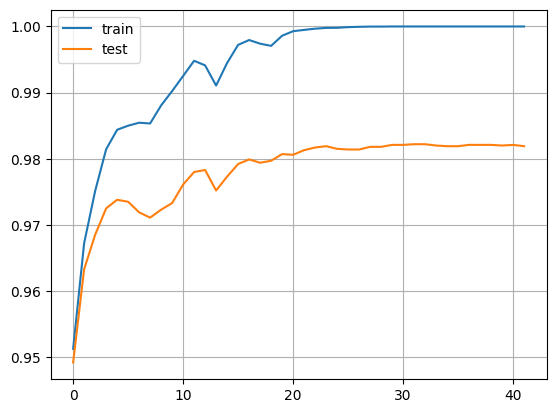

In [9]:
plt.plot(history["accuracy_train"], label="train")
plt.plot(history["accuracy_test"], label="test")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
getTestAccuracy(X_test, Y_test, W1, b1, W2, b2)

0.9819

Jak można zauważyć, nawet tak prosta sieć płytka przy odpowiednio dobranych wartościach  
parametrów wykazuje bardzo dobry wynik **98.19%** dokładności działania na zbiorze testującym.   

Poniżej możemy zobaczyć, jak wyglądają predykcje sieci dla poszczególnych obrazów ze  
zbioru testującego:

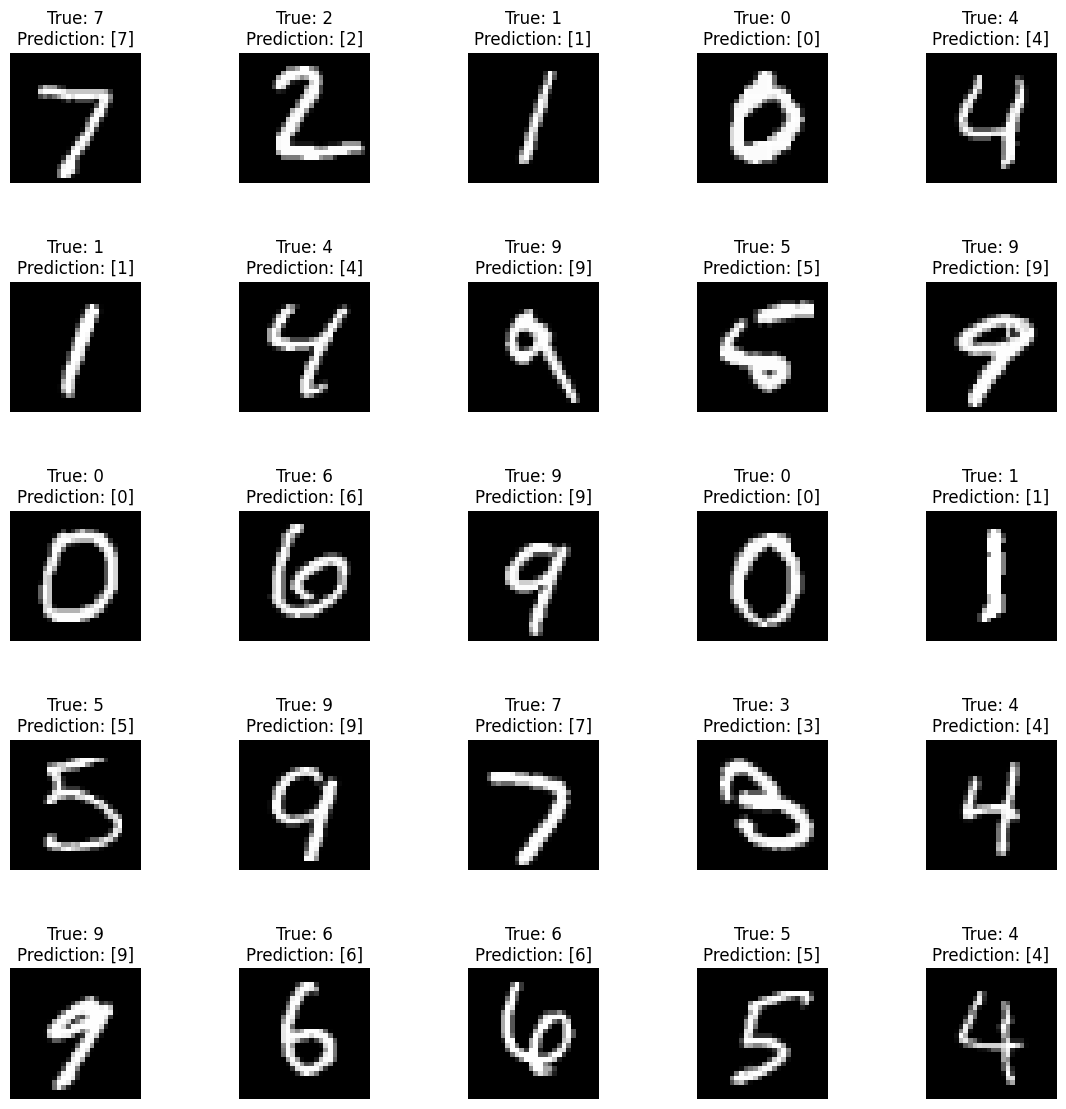

In [18]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
fig.tight_layout(pad=4.0)
axes = axes.ravel()

for i in range(0, 25):
    axes[i].imshow(X_test[:, i].reshape(28, 28))
    axes[i].set_title(f"True: {Y_test[i]}\nPrediction: {makePredictions(X_test[:, i, None], W1, b1, W2, b2)}")
    axes[i].axis('off')

plt.show()